# Implementing KMeansII (Scalable KMeans ++)
### An Implementation of "Scalable KMeans++" by Bahamani et al. [1]
#### Raghav Saboo

## Introduction
The KMeans algorithm thrives as a famous data mining algorithm to cluster data even in the new era of massive datasets because of its inherent simplicity. It however suffers from issues of consistency: even though the cluster centers obtained are locally optimal, there is no guarantee of them being global optimums.

The paper by Bahamani et al. [1] presents a fast, scalable version of an algorithm proposed by Ostrovsky et al. [2] and Arthur and Vassilvitskii [3] dubbed KMeans ++. The advantage provided by the KMeans ++ algorithm are the guarantees provided for the quality of the solution through a procedure generating good initial cluster centers to iterate on. The KMeans ++ initialization results in $O(log k)$ approximation of the optimum, and even a constant approximation "if the data is known to be well clusterable." However KMeans ++ initialization is sequential in nature, and is not parallelizable. This is a significant hurdle to overcome on massive datasets.

This is the problem that Bahamani et al. solve through their KMeans II or Scalable KMeans ++ algorithm. It is the parallelized version of KMeans ++ where instead of sample a single point, it oversamples a couple of centers in each iteration and still provides the same guarantee of cluster centers.

Here I will look to implement the KMeans II algorithm in Python, and look at ways to improve its efficieny even further using Cython, JIT, multiprocessing, and Spark. The effectiveness of the algorithm will be proven through clustering a real life dataset: the SPAM dataset from the UCI ML library. [4] I also will compare the misclassification rate, clustering costs and runtime of the KMeans II algorithm with the KMeans ++ algorithm.

## The KMeansII Algorithm

To be added

## Implementation
### KMeans

In [1]:
%%file distanceFunc.py
import numpy as np

def euclideanDistanceSquared(x, centers):
    """Calculates the squared Euclidean distance of each data point to each cluster center
    
    Definitions:
        n           : Number of points
        d           : Number of dimensions
        k           : Number of cluster centers
    Input:
        x           : (n x d)
        centers     : (k x d)
        
    Output:
        eucDistSq   : (n x k)
    """
    
    eucDistSq = np.sum((x[:, np.newaxis, :] - centers)**2, axis = 2, dtype=float)
    return eucDistSq

Overwriting distanceFunc.py


In [2]:
%%file kMeansFunc.py
import numpy as np
from distanceFunc import euclideanDistanceSquared

def kMeans(x, centers, k, maxIters = 10000):
    """ Apply the KMeans clustering algorithm
    
    Definitions:
        n        : Number of points
        d        : Number of dimensions
        
    Input:
        x        : (n x d) array of data
        centers  : (k x d) array of cluster centers
        k        : number of clusters
        maxIters : maximum number of iterations
        
    Returns:
        iters      : number of iterations to convergence
        centers    : final centers of clusters
        labels     : cluster membership of each point
    """
    
    n = x.shape[0]
    iters = 0
    
    while iters < maxIters:
        eucDist = euclideanDistanceSquared(x, centers)
        
        # labels for each point based argmin(distance to cluster)
        labels = np.argmin(eucDist, axis = 1)
        
        # compute new cluster centers
        newCenters = np.zeros(centers.shape)
        for cluster in range(k):
            if sum(labels == cluster) == 0:
                newCenters[cluster] = centers[cluster]
            else:
                newCenters[cluster] = np.mean(x[labels == cluster, :], axis = 0)
        
        # check for convergence
        if np.array_equal(centers, newCenters):
            print("Converged in %d" % iters)
            break
        
        centers = newCenters
        iters += 1

    return iters, centers, labels

Overwriting kMeansFunc.py


### KMeans ++

In [3]:
%%file kMeansPlusPlusFunc.py
import numpy as np
from distanceFunc import euclideanDistanceSquared
from kMeansFunc import kMeans

def cost(sqDistances):
    """ Cost for each data point based on the minimum distance with respect to cluster centers
    
    Input:
        sqDistance : Squared Euclidean Distance between each data point and the cluster centers
    
    Output:
        cost       : The cost (sum of minimum distances) of the data given current cluster centers
    """ 
    return np.sum(np.min(sqDistances, axis = 1))

def samplingDistribution(sqDistances, cost):
    """ Creates a distribution for the sampling of new cluster centers
    
    Input:
        sqDistances          : Array of squared euclidean distances for each point to each cluster
        costs                : Cost of the data given current cluster centers
    
    Output:
        samplingDistribution : The sampling distribution for cluster membership
    """
    return np.min(sqDistances, axis = 1) / cost

def sampleClusterCenters(x, samplingDist, s):
    """ Samples center points based on the sampling distribution
    
    Input:
        x             : (n x d) array of data
        samplingDist  : (1 x n) probability distribution
        s             : Number of samples
        
    Output:
        sampledPoints : sampled center points
    """
    return x[np.random.choice(range(x.shape[0]), s, p = samplingDist), :]

def kMeansPlusPlus(x, k, maxIters = 10000):
    """ KMeans ++ algorithm
    
    Input:
        x       : (n x d) array of data
        k       : Number of clusters
        maxIters : maximum number of iterations
    
    Output:
        iters      : number of iterations to convergence
        kcenters   : final centers of clusters
        labels     : cluster membership of each point
    """
    # Initialize centers
    centers = x[np.random.choice(x.shape[0], 1), :]
    
    while centers.shape[0] < k:
        
        # Get the distances
        eucDistSq = euclideanDistanceSquared(x, centers)
        
        # Compute the cost of the data given current clusters
        currentCost = cost(eucDistSq)
        
        # Calculate the distribution for sampling a new center
        samplingDist = samplingDistribution(eucDistSq, currentCost)
        
        # Sample a new cluster center
        newCenter = sampleClusterCenters(x, samplingDist, 1)
        
        # Sample new cluster points and append to set
        centers = np.append(centers, newCenter, axis = 0)
    
    # Apply KMeans on data and get cluster membership
    iters, kCenters, labels = kMeans(x, centers, k, maxIters)
    
    return iters, kCenters, labels

Overwriting kMeansPlusPlusFunc.py


### KMeansII

In [5]:
%%file scalableKMeansPlusPlusFunc.py
import numpy as np
from distanceFunc import euclideanDistanceSquared
from kMeansPlusPlusFunc import cost, samplingDistribution, sampleClusterCenters
from kMeansFunc import kMeans

def computeWeights(sqDistances, centers):
    """ Compute the weights of each center based on number of data points closest to each center
    
    Input:
        x         : (n x d) array of data
        centers   : (1 x k) array of centers
        
    Output:
        weights   : (1 x n) array of weights
    """
    
    # Get the closest cluster for each data point
    closestCluster = np.argmin(sqDistances, axis = 1)
    
    # Get the number of points closest to each cluster
    _, closestCount = np.unique(closestCluster, return_counts = True)
    #
    #closestCluster = np.zeros(sqDistances.shape)
    #closestCluster[range(sqDistances.shape[0]), np.argmin(sqDistances, axis = 1)] = 1
    #closestCount = np.array([np.count_nonzero(closestCluster[:, i]) for i in range(centers.shape[0])])
    
    # Return the weights
    return closestCount/np.sum(closestCount)

def weightedKMeans(x, centers, k, weights, maxIters = 10000):
    """ KMeans algorithm that utilizes weights for clustering
    
    Definitions:
        n        : Number of points
        d        : Number of dimensions
        
    Input:
        x        : (n x d) array of data
        centers  : (k x d) array of cluster centers
        k        : number of clusters
        weights  : (1 x k) weights
        maxIters : maximum number of iterations
        
    Returns:
        iters      : number of iterations to convergence
        centers    : final centers of clusters
        labels     : cluster membership of each point
    """
    
    n = x.shape[0]
    iters = 0
    
    while iters < maxIters:
        eucDist = euclideanDistanceSquared(x, centers) * weights[: , np.newaxis]
        
        # labels for each point based argmin(distance to cluster)
        labels = np.argmin(eucDist, axis = 1)
        
        # compute new cluster centers
        newCenters = np.zeros(centers.shape)
        for cluster in range(k):
            if sum(labels == cluster) == 0:
                newCenters[cluster] = centers[cluster]
            else:
                newCenters[cluster] = np.mean(x[labels == cluster, :], axis = 0)
        
        # check for convergence
        if np.array_equal(centers, newCenters):
            print("Converged in %d" % iters)
            break
        
        centers = newCenters
        iters += 1
        
    return centers

def scalableKMeansPlusPlus(x, k, s, maxIters = 10000):
    centers = x[np.random.choice(range(x.shape[0]), 1), :]
    initDistances = euclideanDistanceSquared(x, centers)
    initCost = cost(initDistances)
    
    logCost = int(np.ceil(np.log(initCost)))

    for i in range(logCost):
        # Get the distane between data and centroids
        eucDistSq = euclideanDistanceSquared(x, centers)
        
        # Compute the cost of the data given current clusters
        currentCost = cost(eucDistSq)
        
        # Calculate the distribution for sampling a new center
        samplingDist = samplingDistribution(eucDistSq, currentCost)
        
        # Sample a new cluster center
        newCenter = sampleClusterCenters(x, samplingDist, 1)
        
        # Sample new cluster points and append to set
        centers = np.append(centers, newCenter, axis = 0)
    
    # Reduce (k * l) to k Clusters using KMeans ++
    eucDist = euclideanDistanceSquared(x, centers)
    weights = computeWeights(eucDist, centers)
    initCenters = centers[np.random.choice(range(len(weights)), k, replace = False), :]
    
    # Apply KMeans on data and get cluster membership
    centers = weightedKMeans(centers, initCenters, k, weights, maxIters)
    
    iters, kCenters, labels = kMeans(x, centers, k, maxIters)
    
    return iters, kCenters, labels

Overwriting scalableKMeansPlusPlusFunc.py


In [6]:
%%file test_kmeanspp.py
import numpy as np
from kMeansPlusPlusFunc import kMeansPlusPlus
from scalableKMeansPlusPlusFunc import scalableKMeansPlusPlus

def test_length():
    data = np.random.normal(size=(2000,2))
    k = 3
    l = 5
    kCenters1 = kMeansPlusPlus(data, k)
    kCenters2 = scalableKMeansPlusPlus(data, k, l)
    assert len(kCenters1)==k and len(kCenters2)==k

Overwriting test_kmeanspp.py


In [7]:
! py.test

============================= test session starts ==============================
platform linux -- Python 3.5.1, pytest-2.8.5, py-1.4.31, pluggy-0.3.1
rootdir: /home/ubuntu/notebooks/KMeans II (Scalable KMeans ++), inifile: 
collected 1 items 

test_kmeanspp.py .

=========================== 1 passed in 0.63 seconds ===========================


## Data Simulation

In [56]:
import numpy as np
## Simulate data
np.random.seed(1234)
k = 20
n = 10000
d = 15

## simulate k centers from 15-dimensional spherical Gaussian distribution 
mean = np.hstack(np.zeros((d,1)))
cov = np.diag(np.array([1,10,100]*5))
centers = np.random.multivariate_normal(mean, cov, k)

## Simulate n data
for i in range(k):
    mean = centers[i]
    if i == 0:
        data = np.random.multivariate_normal(mean, np.diag(np.ones(d)), int(n/k+n%k))
        trueLabels = np.repeat(i,int(n/k+n%k))
    else:
        data = np.append(data, np.random.multivariate_normal(mean, np.diag(np.ones(d)) , int(n/k)), axis = 0) 
        trueLabels = np.append(trueLabels,np.repeat(i,int(n/k)))

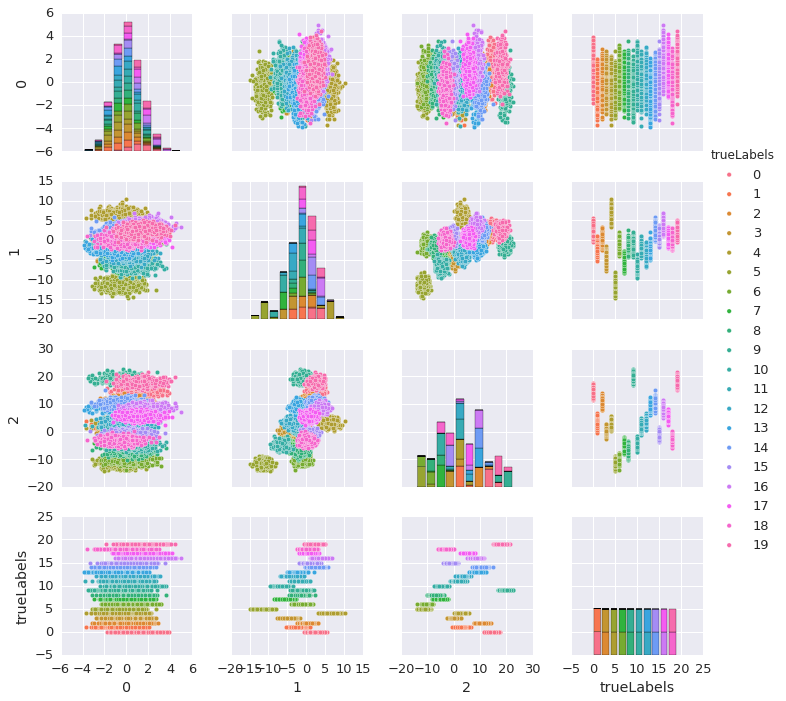

In [57]:
%matplotlib inline
from pandas import DataFrame
data_v = DataFrame(data[:,0:3]) 
data_v['trueLabels'] = trueLabels
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
sns.pairplot(data_v, hue="trueLabels")
pass

In [58]:
from kMeansFunc import kMeans
centroids_initial = data[np.random.choice(range(data.shape[0]), k, replace=False),:]
iterNo, centersKMeans, labelsKMeans = kMeans(data, centroids_initial, k)

Converged in 41


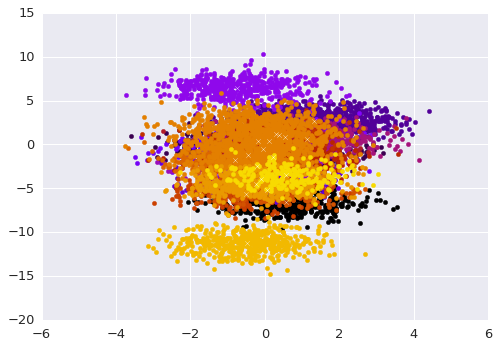

In [59]:
## Plot the first two dimensions
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for i, color in enumerate(colors, start = 1):
    plt.scatter(data[labelsKMeans == i, :][:, 0], data[labelsKMeans == i, :][:, 1], color = color)
    
for j in range(k):
    plt.scatter(centersKMeans[j, 0], centersKMeans[j, 1], color = 'w', marker = 'x')

In [60]:
from kMeansPlusPlusFunc import kMeansPlusPlus
k = 20
iters, centersKMeansPP, labelsKMeansPP = kMeansPlusPlus(data, k)

Converged in 15


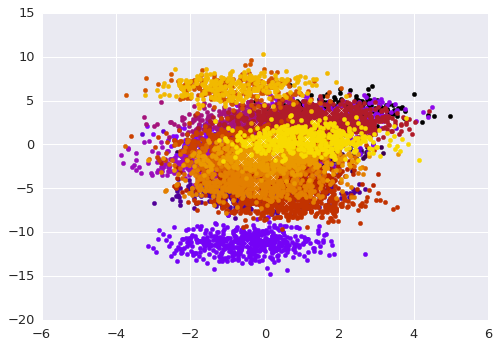

In [61]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labelsKMeansPP==i, :][:,0], data[labelsKMeansPP==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centersKMeansPP[j,0],centersKMeansPP[j,1],color = 'w',marker='x') 

In [71]:
from scalableKMeansPlusPlusFunc import scalableKMeansPlusPlus
l = 10
k = 20
iterNo, centersScalableKMeansPP, labelsScalableKMeansPP = scalableKMeansPlusPlus(data, k, l)

Converged in 2
Converged in 27


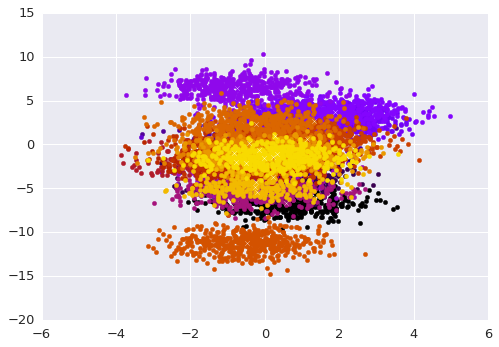

In [72]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labelsScalableKMeansPP==i, :][:,0], data[labelsScalableKMeansPP==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centersScalableKMeansPP[j,0],centersScalableKMeansPP[j,1],color = 'w',marker='x') 

In [34]:
import pandas as pd
from pandas import DataFrame
def MisClassRate(trueLabels, predict):
    """
    Calculate the misclassification rate of the algorithm
    
    Parameters:
    trueLabels   n*1 true labels of each observation  
    predict      n*1 predict labels of each observation 
    
    Returns:     misclassification rate 
    """
    n = len(trueLabels)
    df = DataFrame({'True':trueLabels, 'Predict':predict,'V':1})
    table = pd.pivot_table(df, values ='V', index = ['True'], columns=['Predict'], aggfunc=np.sum).fillna(0)
    misRate = 1-sum(table.max(axis=1))/n
    return misRate

In [74]:
print("Misclassification Rate:")
print("Random:", MisClassRate(trueLabels, labelsKMeans)) # Random 
print("KMeans++:", MisClassRate(trueLabels, labelsKMeansPP)) # KMeans++
print("Scalable KMeans++:", MisClassRate(trueLabels, labelsScalableKMeansPP)) # Scalable KMeans++

Misclassification Rate:
Random: 0.1056
KMeans++: 0.0459
Scalable KMeans++: 0.0456


In [30]:
%timeit -n 2 kMeansPlusPlus(data, k);
%timeit -n 2 scalableKMeansPlusPlus(data, k, l);

Converged in 17
Converged in 14
Converged in 29
Converged in 25
Converged in 13
Converged in 24
2 loops, best of 3: 7.38 s per loop
Converged in 2
Converged in 25
Converged in 3
Converged in 23
Converged in 4
Converged in 23
Converged in 2
Converged in 29
Converged in 2
Converged in 21
Converged in 3
Converged in 25
2 loops, best of 3: 12.3 s per loop


As we can see, the performance is not really great BUT KMeansII is build for parallelization and massive datasets, and currently we haven't taken advantage of that!

## Performance Improvement

### Parallization

In [37]:
from kMeansPlusPlusFunc import sampleClusterCenters
from distanceFunc import euclideanDistanceSquared
from kMeansFunc import kMeans
import numpy as np
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from functools import partial

def minEuclideanDistanceSquared_p(x, centers):
    """Calculates the squared Euclidean distance of each data point to each cluster center
    
    Definitions:
        n           : Number of points
        d           : Number of dimensions
        k           : Number of cluster centers
    Input:
        x           : (n x d)
        centers     : (k x d)
        
    Output:
        eucDistSq   : (n x k)
    """
    
    minEucDistSq = np.min(np.sum((centers - x[np.newaxis, :])**2, axis = 0, dtype=float))
    return minEucDistSq

def cost_p(x, centers):
    """ Cost for each data point based on the minimum distance with respect to cluster centers
    
    Input:
        sqDistance : Squared Euclidean Distance between each data point and the cluster centers
    
    Output:
        cost       : The cost (sum of minimum distances) of the data given current cluster centers
    """ 
    with Pool(processes=cpu_count()) as pool:
        partialDistances = partial(minEuclideanDistanceSquared_p, centers = centers)
        minSqDistances = pool.map(partialDistances, x)
        cost = np.sum(minSqDistances)
        samplingDistribution = minSqDistances/cost
    
    return cost, samplingDistribution, minSqDistances/np.sum(1.)

def minDistanceIndex(d, centers):
    
    minDistIndex = np.argmin(np.sum((centers - d)**2, axis = 1))
    return minDistanceIndex

def randomSample(x, a, p):
    np.random.seed()
    return np.random.choice(a = a, size = x , p =p)


## speed up with multiprocessing
def sample_new_p(data, distribution, l):
    
    """ Sample new centers"""  
    
    with Pool(processes = cpu_count()) as pool:
        partial_rc = partial(randomSample, a = len(distribution), p=distribution)
        index = pool.map(partial_rc,[1]*l)
    return np.squeeze(data[index,:],axis=(1,))

def computeWeights_p(x, centers):
    """ Compute the weights of each center based on number of data points closest to each center
    
    Input:
        x         : (n x d) array of data
        centers   : (1 x k) array of centers
        
    Output:
        weights   : (1 x n) array of weights
    """
    
    with Pool(processes = cpu_count()) as pool:
        partialClosestCluster = partial(minDistanceIndex, centers = centers)
        closestCluster = pool.map(partialClosestCluster, x)
        closestCount = np.array([np.sum(np.array(closestCluster) == i) for i in range(centers.shape[0])])
        
    return closestCount / np.sum(closestCount)

def weightedKMeans_p(x, centers, k, weights, maxIters = 10000):
    """ KMeans algorithm that utilizes weights for clustering
    
    Definitions:
        n        : Number of points
        d        : Number of dimensions
        
    Input:
        x        : (n x d) array of data
        centers  : (k x d) array of cluster centers
        k        : number of clusters
        weights  : (1 x k) weights
        maxIters : maximum number of iterations
        
    Returns:
        iters      : number of iterations to convergence
        centers    : final centers of clusters
        labels     : cluster membership of each point
    """
    
    n = x.shape[0]
    iters = 0
    
    while iters < maxIters:
        #_, _, sqDistances = cost_p(x, centers)
        eucDist = euclideanDistanceSquared(x, centers) * weights[: , np.newaxis]
        #eucDist = sqDistances * weights[: , np.newaxis]
        
        # labels for each point based argmin(distance to cluster)
        labels = np.argmin(eucDist, axis = 1)
        
        # compute new cluster centers
        newCenters = np.zeros(centers.shape)
        for cluster in range(k):
            if sum(labels == cluster) == 0:
                newCenters[cluster] = centers[cluster]
            else:
                newCenters[cluster] = np.mean(x[labels == cluster, :], axis = 0)
        
        # check for convergence
        if np.array_equal(centers, newCenters):
            print("Converged in %d" % iters)
            break
        
        centers = newCenters
        iters += 1
    return iters, centers, labels

def scalableKMeansPlusPlus_p(x, k, s, maxIters = 10000):
    
    centers = x[np.random.choice(range(x.shape[0]), 1), :]
    initCost, _, _ = cost_p(x, centers)
    
    logCost = int(np.ceil(np.log(initCost)))

    for i in range(logCost):        
        # Compute the cost of the data given current clusters
        currentCost, samplingDist, sqDistances = cost_p(x, centers)
        
        # Sample a new cluster center
        newCenter = sample_new_p(x, samplingDist, s)
        # Sample new cluster points and append to set
        centers = np.append(centers, newCenter, axis = 0)
        
    # Reduce (k * l) to k Clusters using KMeans ++
    weights = computeWeights_p(x, centers)
    initCenters = centers[np.random.choice(range(len(weights)), k, replace = False), :]
    
    # Apply KMeans on data and get cluster membership
    _, centers, _ = weightedKMeans_p(centers, initCenters, k, weights, maxIters)
    
    iters, kCenters, labels = kMeans(x, centers, k, maxIters)
    
    return iters, kCenters, labels

In [41]:
k = 20
l = 10
iterNo, kCenters, labels = scalableKMeansPlusPlus_p(data, k, l)

Converged in 1
Converged in 33


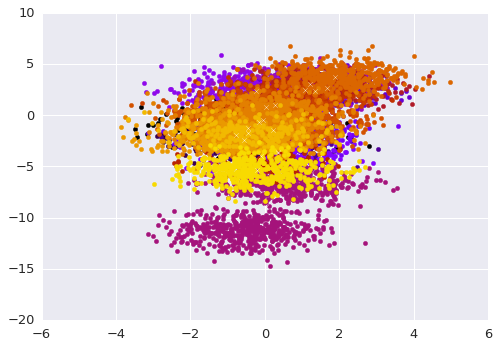

In [42]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 = kCenters
labels1 = labels

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labels1==i, :][:,0], data[labels1==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x') 

In [43]:
%timeit -n 2 scalableKMeansPlusPlus_p(data, k, l);

Converged in 1
Converged in 21
Converged in 1
Converged in 18
Converged in 1
Converged in 14
Converged in 1
Converged in 33
Converged in 1
Converged in 19
Converged in 1
Converged in 27
2 loops, best of 3: 14.9 s per loop


In [28]:
import pandas as pd
import numpy as np
f = open("spambase.data","r")
df = pd.read_table('spambase.data', sep=',', names=range(58))
df = np.array(df)
trueLabels = df[:,57]
df = df[:,0:56]

In [31]:
from kMeansFunc import kMeans
from kMeansPlusPlusFunc import kMeansPlusPlus
from scalableKMeansPlusPlusFunc import scalableKMeansPlusPlus

k = 2

# random
Rcentroids_initial = df[np.random.choice(range(df.shape[0]), k, replace=False),:]
_, Routput_k, labels_k = kMeans(df, Rcentroids_initial, k)

# KMeans++
_, Rcentroids_initial_kpp, labels_kpp = kMeansPlusPlus(df, k)

Converged in 6
Converged in 3


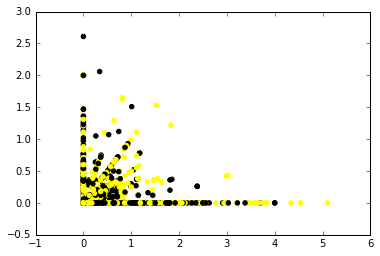

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 = Routput_k
labels1 = labels_k

for i,color in enumerate(colors,start =1):
    plt.scatter(df[labels1==i, :][:,2], df[labels1==i, :][:,10], color=colors)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x') 

In [39]:
# Scalable KMeans++ with l=2/k
_, Rcentroids_initial_spp, labels_ssp = scalableKMeansPlusPlus(df, k, k/2)

# Scalable KMeans++ with l=2*k
_, Rcentroids_initial_spp2k, labels_ssp2k = scalableKMeansPlusPlus(df, k, k*2)

Converged in 3
Converged in 1
Converged in 5
Converged in 1


In [40]:
print("Clustering Error:")
print("Random:", MisClassRate(trueLabels, labels_k)) # Random 
print("KMeans++:",MisClassRate(trueLabels, labels_kpp)) # KMeans++
print("Scalable KMeans++(l=2/k):", MisClassRate(trueLabels, labels_ssp)) # Scalable KMeans++
print("Scalable KMeans++(l=2k):", MisClassRate(trueLabels, labels_ssp2k)) # Scalable KMeans++

Clustering Error:
Random: 0.024777222343
KMeans++: 0.024777222343
Scalable KMeans++(l=2/k): 0.00021734405564
Scalable KMeans++(l=2k): 0.00021734405564


## References
[1] Bahmani, Bahman, et al. "Scalable k-means++." Proceedings of the VLDB Endowment 5.7 (2012): 622-633Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2] R. Ostrovsky, Y. Rabani, L. J. Schulman, and C. Swamy. The effectiveness of Lloyd-type methods for the k-means problem. In FOCS, pages 165–176, 2006.

[3] D. Arthur and S. Vassilvitskii. k-means++: The advantages of careful seeding. In SODA, pages
1027–1035, 2007.

[4] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.